drive_path:  drive/MyDrive/Colab Notebooks/ChainNet/processed_data/12_23___03_14
IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED:  True
AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED:  False
dataset_model:  base
WINDOW_SIZE:  3
PREDICTION_HORIZON:  1
++++++++++++++++++++++++++++++
prediction_total:      rf_base_prediction_3 xgbt_base_prediction_3  gp_base_prediction_3  \
0   [1176.7675750000017]            [1188.7397]  [1025.4373828882565]   
0   [1191.5723750000036]            [1194.0205]  [1039.7193343610852]   
0   [1199.0472500000042]            [1200.3232]   [1035.162743456117]   
0   [1203.8871250000002]            [1207.4668]  [1030.1497685696488]   
0    [1213.113025000003]             [1201.453]  [1037.3754447782217]   
..                   ...                    ...                   ...   
0   [2147.5179256299994]            [2261.8623]   [2081.830933792144]   
0   [2363.4659261050047]            [2384.8054]  [2102.0237603814894]   
0   [2250.3866592224967]            [2219.3694]  [2145.08100194200

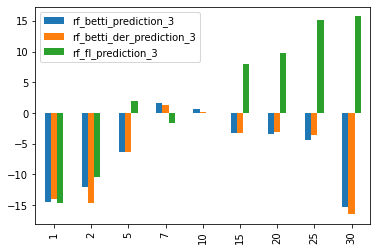

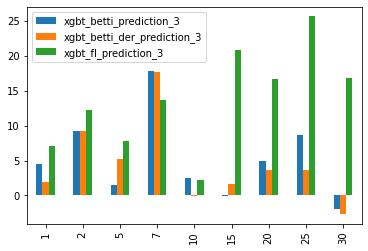

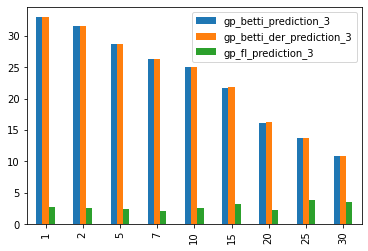

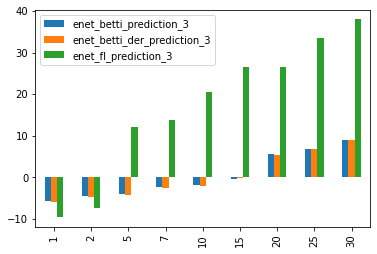

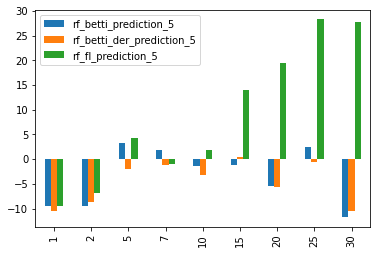

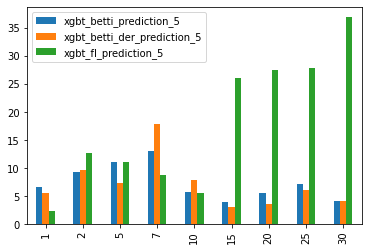

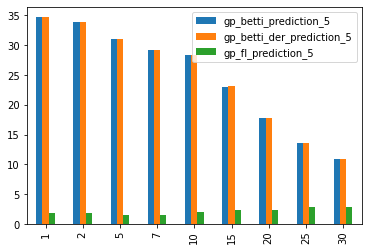

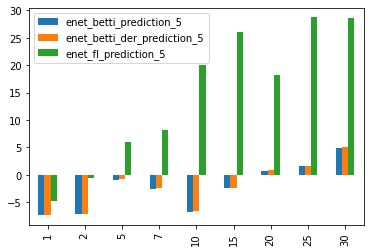

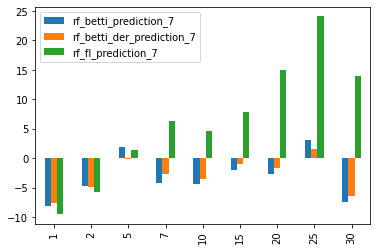

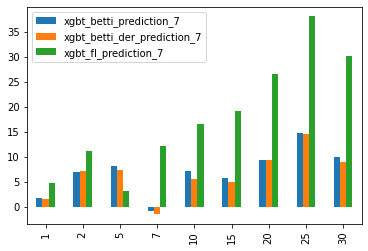

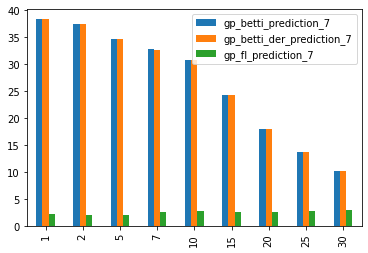

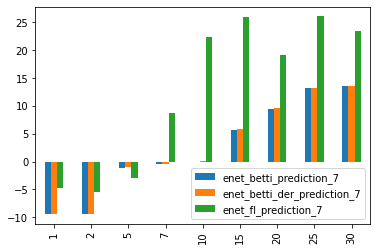

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np, tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import os
import csv
import gc
from sklearn.metrics import mean_squared_error
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn import linear_model
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA
import copy
import pyflux as pf
import datetime


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

PRICED_BITCOIN_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/pricedBitcoin2009-2018.csv"
DAILY_OCCURRENCE_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/dailyOccmatrices/"
betti0_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_0(100).csv"
betti1_input_path = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/betti_1(100).csv"
DAILY_FILTERED_OCCURRENCE_FILE_PATH = "C:/Users/wang.yuhao/Documents/ChainNet/data/original_data/filteredDailyOccMatrices/"

ROW = -1
COLUMN = -1
TEST_SPLIT = 0.01



ALL_YEAR_INPUT_ALLOWED = False
YEAR = 2017
START_YEAR = 2017
END_YEAR = 2018
SLIDING_BATCH_SIZE = 7

# Baseline

from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt

def exclude_days(train, test):

    row, column = train.shape
    train_days = np.asarray(train[:, -1]).reshape(-1, 1)
    x_train = train[:, 0:column - 1]
    test_days = np.asarray(test[:, -1]).reshape(-1, 1)
    x_test = test[:, 0:column - 1]

    return x_train, x_test, train_days, test_days

def merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed):
    if(aggregation_of_previous_days_allowed):
        if(occurrence_data.size==0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.add(occurrence_data, daily_occurrence_normalized_matrix)
    else:
        if(occurrence_data.size == 0):
            occurrence_data = daily_occurrence_normalized_matrix
        else:
            occurrence_data = np.concatenate((occurrence_data, daily_occurrence_normalized_matrix), axis=0)
   #print("merge_data shape: {} occurrence_data: {} ".format(occurrence_data.shape, occurrence_data))

    return occurrence_data
    
    
def get_normalized_matrix_from_file(day, year, totaltx):
    daily_occurrence_matrix_path_name = DAILY_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + '.csv'
    daily_occurence_matrix = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx

def fl_get_normalized_matrix_from_file(day, year, totaltx, n_components):
    daily_occurence_matrix = np.asarray([],dtype=np.float32)
    for filter_number in range(0, 50, 10):
        daily_occurrence_matrix_path_name = DAILY_FILTERED_OCCURRENCE_FILE_PATH + "occ" + str(year) + '{:03}'.format(day) + "_" + str(filter_number) +'.csv'
        daily_occurence_matrix_read = pd.read_csv(daily_occurrence_matrix_path_name, sep=",", header=None).values
        if(daily_occurence_matrix.size == 0):
            daily_occurence_matrix = daily_occurence_matrix_read
        else:
            daily_occurence_matrix = np.concatenate((daily_occurence_matrix, daily_occurence_matrix_read), axis = 1)
            

    #print("daily_occurence_matrix: ", daily_occurence_matrix, daily_occurence_matrix.shape)
    #return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)/totaltx
    return np.asarray(daily_occurence_matrix).reshape(1, daily_occurence_matrix.size)


def get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
   #print("priced_bitcoin: ", priced_bitcoin, priced_bitcoin.shape)
   #print("current_row: ", current_row, current_row.shape)
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
           #print("previous_price_data: ", previous_price_data,row['day'], row['year'], row['totaltx'])

   #print("occurrence_data: ", occurrence_data)
    if(is_price_of_previous_days_allowed):
       #print("previous_price_data: ", np.asarray(previous_price_data).reshape(1, -1), np.asarray(previous_price_data).reshape(1, -1).shape)
        occurrence_data = np.asarray(previous_price_data).reshape(1, -1)
    occurrence_input = np.concatenate((occurrence_data, np.asarray(current_row['price']).reshape(1,1)), axis=1)
   #print("current_row: ", current_row, current_row.shape)
   #print(" price occurrence_input: ", np.asarray(current_row['price']).reshape(1,1), (np.asarray(current_row['price']).reshape(1,1)).shape)
   #print("concatenate with price occurrence_input: ", occurrence_input, occurrence_input.shape)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
   #print(" price occurrence_input: ", np.asarray(current_row['day']).reshape(1,1), (np.asarray(current_row['day']).reshape(1,1)).shape)

   #print("concatenate with day occurrence_input: ", occurrence_input, occurrence_input.shape)
    return occurrence_input


def betti_get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
            betti0_50 = read_betti(betti0_input_path, row['day'])
            occurrence_data = np.append(occurrence_data, np.asarray(betti0_50).reshape(1,-1))
            betti1_50 = read_betti(betti1_input_path, row['day'])
            occurrence_data = np.append(occurrence_data, np.asarray(betti1_50).reshape(1,-1))

            
    if (is_price_of_previous_days_allowed):
        occurrence_data = np.concatenate((np.asarray(previous_price_data).reshape(1,-1),occurrence_data.reshape(1,-1)),  axis=1)

    occurrence_input = np.concatenate((occurrence_data.reshape(1,-1), np.asarray(current_row['price']).reshape(1,1)), axis=1)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
    #print("occurrence_input: ",occurrence_input, occurrence_input.shape)
    return occurrence_input

def betti_der_get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)

    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
            betti0_50 = read_betti(betti0_input_path, row['day'])
            occurrence_data = np.append(occurrence_data, np.asarray(betti0_50).reshape(1,-1))
            betti1_50 = read_betti(betti1_input_path, row['day'])
            occurrence_data = np.append(occurrence_data, np.asarray(betti1_50).reshape(1,-1))
            betti0_50_diff1 = betti0_50.diff(1).dropna() 
            occurrence_data = np.concatenate((occurrence_data.reshape(1,-1), np.asarray(betti0_50_diff1).reshape(1,-1)), axis=1)
            betti1_50_diff1 = betti1_50.diff(1).dropna()
            occurrence_data = np.concatenate((occurrence_data, np.asarray(betti1_50_diff1).reshape(1,-1)), axis=1)
            #print("previous_price_data:",previous_price_data, previous_price_data.shape)
  
    if (is_price_of_previous_days_allowed):
        occurrence_data = np.concatenate((np.asarray(previous_price_data).reshape(1,-1),occurrence_data.reshape(1,-1)),  axis=1)

    occurrence_input = np.concatenate((occurrence_data.reshape(1,-1), np.asarray(current_row['price']).reshape(1,1)), axis=1)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
    #print("occurrence_input: ",occurrence_input, occurrence_input.shape)
    return occurrence_input

def fl_get_daily_occurrence_matrices(priced_bitcoin, current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    previous_price_data = np.array([], dtype=np.float32)
    occurrence_data = np.array([], dtype=np.float32)
    for index, row in priced_bitcoin.iterrows():
        if not ((row.values == current_row.values).all()):
            previous_price_data = np.append(previous_price_data, row['price'])
            previous_price_data = np.append(previous_price_data, row['totaltx'])
            daily_occurrence_normalized_matrix = fl_get_normalized_matrix_from_file(row['day'], row['year'], row['totaltx'], 20)
            occurrence_data = merge_data(occurrence_data, daily_occurrence_normalized_matrix, aggregation_of_previous_days_allowed)

    #print("occurrence_data: ",occurrence_data, occurrence_data.shape)
    if (is_price_of_previous_days_allowed):
        occurrence_data = np.concatenate((np.asarray(previous_price_data).reshape(1,-1),occurrence_data.reshape(1,-1)),  axis=1)

    occurrence_input = np.concatenate((occurrence_data.reshape(1,-1), np.asarray(current_row['price']).reshape(1,1)), axis=1)
    occurrence_input = np.concatenate((occurrence_input, np.asarray(current_row['day']).reshape(1,1)), axis=1)
    #print("occurrence_input: ",occurrence_input, occurrence_input.shape)
    return occurrence_input


def read_betti(file_path, day):
    day = day - 1
    betti = pd.read_csv(file_path, index_col=0)
    try:
        betti_50 = betti.iloc[day, 0:50]
    except:
        print("day:",  day)
            
    return betti_50


def rf_mode(train_input, train_target, test_input, test_target):
    param = {
        'n_estimators':400
        }

    rf_regression = RandomForestRegressor(**param)
    rf_regression.fit(train_input, train_target.ravel() )
    rf_predicted = rf_regression.predict(test_input)
    return rf_predicted

def gp_mode(train_input, train_target, test_input, test_target):
    param = {
        'kernel': RationalQuadratic(alpha=0.01, length_scale=1),
        'n_restarts_optimizer': 2
        }

    gpr = GaussianProcessRegressor(**param)
    gpr.fit(train_input,train_target.ravel())
    gp_predicted = gpr.predict(test_input)

    return gp_predicted
    
def enet_mode(train_input, train_target, test_input, test_target):
    param = {
        'alpha': 10,
        'l1_ratio': 1,
        }
    elastic = linear_model.ElasticNet(**param)

    elastic.fit(train_input,train_target.ravel())  
    enet_predicted = elastic.predict(test_input) 
    return enet_predicted

def xgbt_mode(train_input, train_target, test_input, test_target):
    param = {
        'n_estimators':1000,
        'learning_rate': 0.01,
        'objective': 'reg:squarederror', 
        }

    xgbt = XGBRegressor(**param)
    xgbt.fit(train_input,train_target.ravel())  
    xgbt_predicted = xgbt.predict(test_input) 
    return xgbt_predicted


    
def arimax_initialize_setting(dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    data = preprocess_data(dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)

    train = data[0:100, :]
    test = data[100:100+prediction_horizon, :]

    x_train, x_test, train_days, test_days = exclude_days(train, test)

    row, column = x_train.shape
    train_target = np.asarray(x_train[:, -1]).reshape(-1)
    train_input = x_train[:, 0:column - 1]

    test_target = x_test[: , -1]
    test_input = x_test[ : , 0:column - 1]
    return train_input, train_target, test_input, test_target, train_days, test_days


def arimax_base_rmse_mode(train_input, train_target, test_input, test_target):
    train_input_diff_arr = np.array([])
    train_columns_name = []
    train_input_column = int(train_input.shape[1])
    for i in range(train_input_column):
        if(i%2==0):
            train_columns_name.append('price_' + str(i))
        else:
            train_columns_name.append('totaltx_' + str(i))
        train_input_diff = np.diff(train_input[:,i] )
        if i == 0:
            train_input_diff_arr = train_input_diff
        else:
            train_input_diff_arr = np.dstack((train_input_diff_arr, train_input_diff))

    columns_name = copy.deepcopy(train_columns_name)
    columns_name.append('current_price')
    train_target_diff = np.diff(train_target )
    train_input_diff_arr = np.dstack((train_input_diff_arr, train_target_diff))

    train_input_diff_arr = pd.DataFrame(train_input_diff_arr[0], columns = columns_name)

    model  = pf.ARIMAX(data=train_input_diff_arr,formula="current_price~totaltx_5",ar=1,ma=2,integ=0)


    model_1 = model.fit("MLE")
    model_1.summary()


    test_input_pd = pd.DataFrame(test_input, columns = train_columns_name)
    test_target_pd = pd.DataFrame(test_target, columns = ['current_price'])
    test_input_target = pd.concat([test_input_pd, test_target_pd], axis=1)

    pred = model.predict(h=test_input_target.shape[0],
                               oos_data=test_input_target, 
                                   intervals=True, )
    arimax_base_rmse = mean_squared_error([test_input_target.iloc[0, 6]],[(train_target[99])+pred.current_price[99]])
    print("arimax_base_rmse:",arimax_base_rmse)
    return arimax_base_rmse

def run_print_model(train_input, train_target, test_input, test_target, train_days, test_days):
    rf_prediction = rf_mode(train_input, train_target, test_input, test_target)
    xgbt_prediction = xgbt_mode(train_input, train_target, test_input, test_target)
    gp_prediction = gp_mode(train_input, train_target, test_input, test_target)
    enet_prediction = enet_mode(train_input, train_target, test_input, test_target)
    
    return rf_prediction, xgbt_prediction, gp_prediction, enet_prediction
    #print_results(predicted, test_target, original_log_return, predicted_log_return, cost, test_days, rmse)
    #return rf_base_rmse
    
    
def filter_data(priced_bitcoin, window_size):
    end_day_of_previous_year = max(priced_bitcoin[priced_bitcoin['year'] == START_YEAR-1]["day"].values)
    start_index_of_previous_year = end_day_of_previous_year - window_size
    previous_year_batch = priced_bitcoin[(priced_bitcoin['year'] == START_YEAR-1) & (priced_bitcoin['day'] > start_index_of_previous_year)]
    input_batch = priced_bitcoin[(priced_bitcoin['year'] >= START_YEAR) & (priced_bitcoin['year'] <= END_YEAR)]
    filtered_data = previous_year_batch.append(input_batch)
    filtered_data.insert(0, 'index', range(0, len(filtered_data)))
    filtered_data = filtered_data.reset_index(drop=True)
    return filtered_data


def preprocess_data(dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    priced_bitcoin = pd.read_csv(PRICED_BITCOIN_FILE_PATH, sep=",")
    if(ALL_YEAR_INPUT_ALLOWED):
        pass
    else:
        
        #priced_bitcoin = filter_data(priced_bitcoin, window_size)
        priced_bitcoin = priced_bitcoin[priced_bitcoin['year']==YEAR].reset_index(drop=True)
        
    #print("priced_bitcoin:",priced_bitcoin)
    daily_occurrence_input = np.array([],dtype=np.float32)
    temp = np.array([], dtype=np.float32)
    for current_index, current_row in priced_bitcoin.iterrows():
        if(current_index<(window_size+prediction_horizon-1)):
            pass
        else:
            start_index = current_index - (window_size + prediction_horizon) + 1
            end_index = current_index - prediction_horizon
            if(dataset_model=="base"):
                temp = get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            elif(dataset_model=="betti"):
                temp = betti_get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            elif(dataset_model=="fl"):
                temp = fl_get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            elif(dataset_model=="betti_der"):
                temp = betti_der_get_daily_occurrence_matrices(priced_bitcoin[start_index:end_index+1], current_row, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)    
            else:
                sys.exit("Dataset model support only baseline, betti, fl and betti_der!")
        if(daily_occurrence_input.size == 0):
            daily_occurrence_input = temp
        else:
            daily_occurrence_input = np.concatenate((daily_occurrence_input, temp), axis=0)
    return daily_occurrence_input
        
def initialize_setting( features, price, day, test_start, dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed):
    train_target = price[test_start : test_start + 100]
    train_days = day[test_start : test_start + 100]
    pca_features = features[test_start : test_start + 100+1, :]

    train_input = pca_features[0 : 100, :]
    #x_test = x_test.reshape(-1,1)
    test_target = price[test_start + 100]
    test_days = day[test_start + 100]
    #print(pca_features, pca_features.shape)
    test_input = pca_features[ 100, :].reshape(1, -1)
    #print(pca_features, pca_features.shape)
    #print("***"*20)
    #print(train_input,train_input.shape, train_target, test_input,test_input.shape, test_target, train_days, test_days)
    return train_input, train_target, test_input, test_target, train_days, test_days

def split_process(data,dataset_model,window_size):
    baseline_features = data[:, 0:window_size*2]
    fl_features = data[: , window_size*2:-2]
    price = data[:, -2]
    day = data[:,-1]

    return baseline_features, fl_features, price, day

parameter_dict = {#0: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':True})}
                  1: dict({'is_price_of_previous_days_allowed':True, 'aggregation_of_previous_days_allowed':False})}

for step in parameter_dict:
    t = datetime.datetime.now()
    dir_name = t.strftime('%m_%d___%H_%M')
    drive_path = "drive/MyDrive/Colab Notebooks/ChainNet/processed_data/"+dir_name
    if not os.path.exists(dir_name):
        os.makedirs(drive_path)
        print("drive_path: ", drive_path)
    result_path = drive_path + "/"
    
    names = locals()
    gc.collect()
    evalParameter = parameter_dict.get(step)
    is_price_of_previous_days_allowed = evalParameter.get('is_price_of_previous_days_allowed')
    aggregation_of_previous_days_allowed = evalParameter.get('aggregation_of_previous_days_allowed')
    print("IS_PRICE_OF_PREVIOUS_DAYS_ALLOWED: ", is_price_of_previous_days_allowed)
    print("AGGREGATION_OF_PREVIOUS_DAYS_ALLOWED: ", aggregation_of_previous_days_allowed)
    window_size_array = [3, 5, 7]
    horizon_size_array = [1, 2, 5, 7, 10, 15, 20, 25, 30]
    dataset_model_array = ["base","betti", "betti_der","fl"]
    for dataset_model in dataset_model_array:
        print('dataset_model: ', dataset_model)

        for window_size in window_size_array:
            print('WINDOW_SIZE: ', window_size)
            for prediction_horizon in horizon_size_array:
                data = preprocess_data(dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
                baseline_features, fl_features, price, day = split_process(data, dataset_model, window_size)
                if dataset_model == "base":
                    #print("features: ", baseline_features, fl_features, price, day)
                    features = baseline_features
                    #print("pca features: ", features, features.shape)
                else:
                    #print("features: ", baseline_features, fl_features, price, day)
                    pca = PCA(n_components = 20)
                    pca.fit(fl_features)
                    fl_features = pca.transform(fl_features)
                    features = np.concatenate((baseline_features, fl_features), axis=1)
                    #print("pca features: ", features, features.shape)

                print("PREDICTION_HORIZON: ", prediction_horizon)
                for test_start in range(0, 100):
                    #print("test_start: ", test_start)
                    train_input, train_target, test_input, test_target, train_days, test_days = initialize_setting( features, price, day, test_start, dataset_model, window_size, prediction_horizon, is_price_of_previous_days_allowed, aggregation_of_previous_days_allowed)
                    rf_prediction, xgbt_prediction, gp_prediction, enet_prediction = run_print_model(train_input, train_target, test_input, test_target, train_days, test_days)
                    
                    prediction = pd.DataFrame({'rf_' + dataset_model + '_prediction_'+str(window_size): [rf_prediction], 'xgbt_' + dataset_model + '_prediction_'+str(window_size): [xgbt_prediction], 'gp_' + dataset_model + '_prediction_'+str(window_size): [gp_prediction], 'enet_' + dataset_model + '_prediction_'+str(window_size): [enet_prediction]})
                    test_target_df = pd.DataFrame({'test_target': [test_target]})

                    #print("prediction: ",prediction)
                    if(test_start==0):
                        prediction_total = prediction
                        test_target_total = test_target_df
                    else:
                        prediction_total = [prediction_total, prediction]
                        test_target_total = [test_target_total, test_target_df]
                        prediction_total = pd.concat(prediction_total)
                        test_target_total = pd.concat(test_target_total)

                print("+++"*10)
                print("prediction_total: ",prediction_total)
                print("test_target_total: ",test_target_total)
                rmse = ((((prediction_total.sub(test_target_total.values))**2).mean())**0.5).to_frame().T
                print("rmse: ",rmse)
                #rmse.to_csv(result_path + "rmse_" + dataset_model + "_"+ str(window_size) +"_"+ str(prediction_horizon) + ".csv", index=True)

                if(prediction_horizon==1):
                    rmse_total = rmse
                else:
                    rmse_total = [rmse_total, rmse]
                    rmse_total = pd.concat(rmse_total)

                    
            if(window_size==3):
                names['rmse_' + dataset_model + '_total'] = rmse_total
            else:
                names['rmse_' + dataset_model + '_total'] = pd.concat([names.get('rmse_' + dataset_model + '_total') , rmse_total], axis=1)
               
        names['rmse_' + dataset_model + '_total'].index = pd.Series(horizon_size_array)
        names.get('rmse_' + dataset_model + '_total').to_csv(result_path + "rmse_" + dataset_model + "_total.csv", index=True)
        print('rmse_{}_total = {}'.format(dataset_model, names.get('rmse_' + dataset_model + '_total')))        


    betti_gain = 100 * (1 -rmse_betti_total.div(rmse_base_total.values))
    fl_gain = 100 * (1 -rmse_fl_total.div(rmse_base_total.values))
    betti_der_gain = 100 * (1 -rmse_betti_der_total.div(rmse_base_total.values))
    for i in range(12):

            perf = pd.concat([betti_gain.iloc[:,i],betti_der_gain.iloc[:,i], fl_gain.iloc[:, i]], axis=1).plot.bar()
            modelnames = ["rf","xgbt","gp","enet"]
            windows = [3, 5, 7]
            filename = result_path + modelnames[int(i%4)] +"_window_" + str(windows[int(i/4)]) 
            perf.figure.savefig(filename)
            
            
    horizon_size_array_str = [str(x) for x in horizon_size_array]
    rmse_base_total.index = pd.Series(horizon_size_array_str)
    base_rmse_window_3_line = rmse_base_total.iloc[:,0:4].plot()
    base_rmse_window_3_line.figure.savefig(result_path + "base_rmse_window_3_line")
    base_rmse_window_5_line = rmse_base_total.iloc[:,4:8].plot()
    base_rmse_window_5_line.figure.savefig(result_path + "base_rmse_window_5_line")
    base_rmse_window_7_line = rmse_base_total.iloc[:,8:12].plot()
    base_rmse_window_7_line.figure.savefig(result_path + "base_rmse_window_7_line")

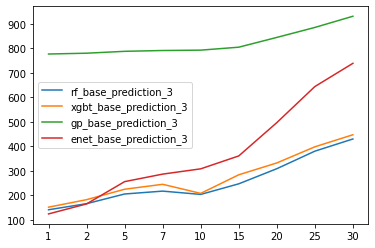

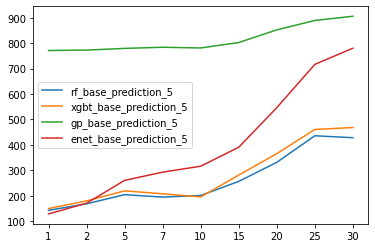

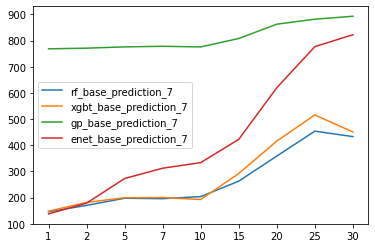

In [20]:
horizon_size_array_str = [str(x) for x in horizon_size_array]
rmse_base_total.index = pd.Series(horizon_size_array_str)
base_rmse_window_3_line = rmse_base_total.iloc[:,0:4].plot()
base_rmse_window_3_line.figure.savefig(result_path + "base_rmse_window_3_line")
base_rmse_window_5_line = rmse_base_total.iloc[:,4:8].plot()
base_rmse_window_5_line.figure.savefig(result_path + "base_rmse_window_5_line")
base_rmse_window_7_line = rmse_base_total.iloc[:,8:12].plot()
base_rmse_window_7_line.figure.savefig(result_path + "base_rmse_window_7_line")

In [22]:
pd.Series(horizon_size_array).map(str)

0     1
1     2
2     5
3     7
4    10
5    15
6    20
7    25
8    30
dtype: object

In [16]:
horizon_size_array_str

['1', '2', '5', '7', '10', '15', '20', '25', '30']

In [18]:
rmse_base_total.index

Index(['1', '2', '5', '7', '10', '15', '20', '25', '30'], dtype='object')

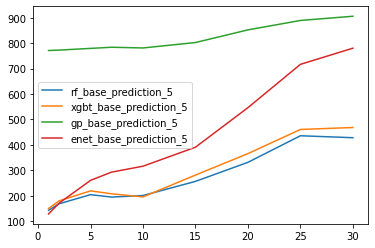

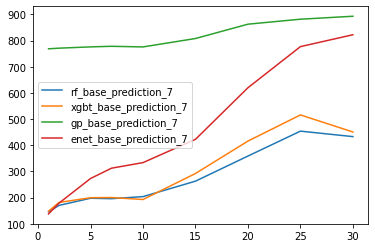

In [9]:
base_rmse_window_5_line = rmse_base_total.iloc[:,4:8].plot()
base_rmse_window_5_line.figure.savefig(result_path + "base_rmse_window_5_line")
base_rmse_window_7_line = rmse_base_total.iloc[:,8:12].plot()
base_rmse_window_7_line.figure.savefig(result_path + "base_rmse_window_7_line")

In [5]:
rmse_base_total

,rf_base_prediction_3,xgbt_base_prediction_3,gp_base_prediction_3,enet_base_prediction_3,rf_base_prediction_5,xgbt_base_prediction_5,gp_base_prediction_5,enet_base_prediction_5,rf_base_prediction_7,xgbt_base_prediction_7,gp_base_prediction_7,enet_base_prediction_7
1,141.050284,151.553316,776.567054,124.037685,142.523240,149.502650,771.266991,128.284610,145.786065,148.124044,768.570659,137.499366
2,165.827474,182.178354,779.875659,164.840201,168.054960,179.566158,772.908108,170.459356,170.114172,181.360842,771.020991,178.745222
5,205.346293,224.758359,787.554790,255.800992,204.102385,218.929098,779.578718,260.277625,197.427462,199.453303,775.925461,272.818421
7,217.064995,244.877684,790.899417,286.463284,194.499169,207.575131,784.102684,292.624348,195.729237,200.114292,778.202594,312.277755
10,203.625019,207.840756,792.371627,308.020307,200.691091,195.128419,781.295018,316.051252,203.639229,192.540256,775.791925,333.580871
15,246.868432,283.717624,804.411654,360.707299,256.313432,281.149533,802.661563,390.775449,262.708929,292.004195,807.956834,422.562296
20,308.539799,332.081105,844.280375,496.599873,331.333428,365.559256,852.475532,546.519139,358.682565,415.902993,862.719006,619.848543
25,380.145059,397.890110,885.018945,643.795781,435.816740,460.583912,889.465202,716.819434,453.888456,515.852770,881.735473,776.968613
30,429.836067,447.096097,930.709252,738.573160,428.173970,468.323542,906.093690,780.388748,432.951173,450.646536,893.051243,822.359677


In [ ]:
rmse_base_total.iloc[:,0:4].plot()